# Advanced Certification Programme in AI and MLOps
## A programme by IISc and TalentSprint
### Additional Notebook: Model Calibration

(Ungraded)

## Introduction

**What is model calibration?**

Model calibration adjusts a model's outputs to ensure they reflect true probabilities. In binary classification, an uncalibrated model's output, such as 0.4 for predicting a dog, cannot be interpreted directly as a probability. Calibration ensures that if the model outputs 0.4, then ideally, 4 out of 10 such predictions would indeed be dogs. This process aligns the model's predicted probabilities with actual outcomes, making them more interpretable and reliable.

**When to calibrate models and why it is critical?**

Calibration is vital for applications where accurate probability estimates are crucial, such as predicting fire alarms. For an uncalibrated model, a prediction score of 0.9 does not reliably indicate that a fire is three times more likely than a score of 0.3. Calibration ensures these scores can be interpreted correctly, allowing for informed decision-making.

For example, if improving a fire detection system costs $200,000, a calibrated model helps determine whether a change in prediction scores (from 0.3 to 0.35 and 0.9 to 0.7) justifies the investment. Without calibration, these scores lack meaningful interpretation, making it difficult to assess potential gains accurately.

Model calibration is particularly important in production environments where models are continually improved through learning and feedback. Accurate probability estimates enable better risk assessment, resource allocation, and overall decision-making, ensuring the model's outputs are reliable and actionable.

In this notebook, we will learn about calibrating machine learning models to obtain sensible and interpretable probabilities as outputs

**Learning Outcomes:**

- What is model calibration and why it is important

- When to and When NOT to calibrate models

- How to assess whether a model is calibrated (reliability curves)

- Different techniques to calibrate a Machine Learning model




## Dataset Description

**The Customer Churn** table contains information on all 7,043 customers from a Telecommunications company in California for Q2 2022.

This dataset contains 2 tables, in CSV format:

Each record represents one customer, and contains details about their demographics, location, tenure, subscription services, status for the quarter (joined, stayed, or churned), and more!
The Zip Code Population table contains complimentary information on the estimated populations for the California zip codes in the Customer Churn table

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [1]:
!kaggle datasets download -d shilongzhuang/telecom-customer-churn-by-maven-analytics

Dataset URL: https://www.kaggle.com/datasets/shilongzhuang/telecom-customer-churn-by-maven-analytics
License(s): other
  0% 0.00/434k [00:00<?, ?B/s]
100% 434k/434k [00:00<00:00, 18.0MB/s]


In [2]:
!unzip /content/telecom-customer-churn-by-maven-analytics.zip

Archive:  /content/telecom-customer-churn-by-maven-analytics.zip
  inflating: telecom_customer_churn.csv  
  inflating: telecom_data_dictionary.csv  
  inflating: telecom_zipcode_population.csv  


In [5]:
!pip -q install ml_insights
!pip -q install dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 4.2 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ml_insights as mli
%matplotlib inline
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, f1_score
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

In [7]:
data = pd.read_csv('/content/telecom_customer_churn.csv')
data.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              3166 non-null   objec

In [9]:
data = data.iloc[:,[1,2,3,4,9,10,11,12,15,26,27,28,29,30,31,32,33,34,35]]

In [10]:
data = data[data['Customer Status']!='Joined'].reset_index(drop=True)

In [11]:
data['Customer Status'].value_counts()

,count
Customer Status,
Stayed,4720
Churned,1869


In [12]:
data['Customer Status'] = data['Customer Status'].apply(lambda x: 1 if x=='Churned' else 0)

In [13]:
data['Customer Status'].value_counts()

,count
Customer Status,
0,4720
1,1869


In [14]:
data.head()

,Gender,Age,Married,Number of Dependents,Number of Referrals,Tenure in Months,Offer,Phone Service,Internet Service,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status
0,Female,37,Yes,0,2,9,NaN,Yes,Yes,One Year,Yes,Credit Card,65.6,593.30,0.00,0,381.51,974.81,0
1,Male,46,No,0,0,9,NaN,Yes,Yes,Month-to-Month,No,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,0
2,Male,50,No,0,0,4,Offer E,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,1
3,Male,78,Yes,0,1,13,Offer D,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,1
4,Female,75,Yes,0,3,3,NaN,Yes,Yes,Month-to-Month,Yes,Credit Card,83.9,267.40,0.00,0,22.14,289.54,1


In [15]:
# Extract categoricals and their indices
cat_features = data.select_dtypes(exclude=np.number).columns.to_list()
cat_idx = [data.columns.get_loc(col) for col in cat_features]

# Convert cat_features to pd.Categorical dtype
for col in cat_features:
    data[col] = pd.Categorical(data[col])

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6589 entries, 0 to 6588
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Gender                       6589 non-null   category
 1   Age                          6589 non-null   int64   
 2   Married                      6589 non-null   category
 3   Number of Dependents         6589 non-null   int64   
 4   Number of Referrals          6589 non-null   int64   
 5   Tenure in Months             6589 non-null   int64   
 6   Offer                        2991 non-null   category
 7   Phone Service                6589 non-null   category
 8   Internet Service             6589 non-null   category
 9   Contract                     6589 non-null   category
 10  Paperless Billing            6589 non-null   category
 11  Payment Method               6589 non-null   category
 12  Monthly Charge               6589 non-null   float64 
 13  Tot

#Splitting the data

In [17]:
# Set the percentage splits for the training, validation, and test datasets
train_perc = 0.4
val_perc = 0.3
test_perc = 0.3

# Set the random seed for reproducibility
rs = 1234

# Split the data into a combined training/validation set and a test set
# 'test_size=test_perc' means 30% of the data will be assigned to the test set
# 'random_state=rs' ensures the split is reproducible
# 'stratify=data.iloc[:,-1]' ensures the split maintains the same proportion of classes as in the original data
X_train_val, X_test, y_train_val, y_test = train_test_split(
    data.iloc[:, :-1],  # Features
    data.iloc[:, -1],   # Labels
    test_size=test_perc,
    random_state=rs,
    stratify=data.iloc[:, -1]
)

# Split the combined training/validation set into separate training and validation sets
# 'test_size=val_perc' means 30% of the remaining data (after removing the test set) will be assigned to the validation set
# 'random_state=rs' ensures the split is reproducible
# 'stratify=y_train_val' ensures the split maintains the same proportion of classes as in the original data
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,  # Combined training/validation features
    y_train_val,  # Combined training/validation labels
    test_size=val_perc,
    random_state=rs,
    stratify=y_train_val
)


In [19]:
# Check the shape of the training set features (X_train) and labels (y_train)
X_train.shape, y_train.shape

# Check the shape of the validation set features (X_val) and labels (y_val)
X_val.shape, y_val.shape

# Check the shape of the test set features (X_test) and labels (y_test)
X_test.shape, y_test.shape


((1977, 18), (1977,))

In [18]:
y_train.value_counts()

,count
Customer Status,
0,2313
1,915


In [20]:
y_val.value_counts()

,count
Customer Status,
0,991
1,393


In [21]:
y_test.value_counts()

,count
Customer Status,
0,1416
1,561


#Uncallibrated Model

In [22]:
# Measure the time taken to execute the following code block
%%time

# Initialize the LightGBM classifier with specified hyperparameters
lgbm_clf = lgbm.LGBMClassifier(
    objective="binary",       # Set the objective to binary classification
    random_state=rs,          # Ensure reproducibility with a fixed random seed
    n_estimators=10,          # Set the number of boosting iterations (trees)
    boosting="gbdt",          # Use Gradient Boosting Decision Trees (default method)
    class_weight="balanced",  # Adjust weights to handle class imbalance
)

# Train the LightGBM classifier on the training data
# 'categorical_feature=cat_idx' specifies which features are categorical
lgbm_clf.fit(
    X_train,      # Training features
    y_train,      # Training labels
    categorical_feature=cat_idx  # List of indices of categorical features
)

# Predict probabilities for the validation set
# 'predict_proba' returns the probability of each class, [:,1] extracts the probability of the positive class
preds_uncalibrated_val = lgbm_clf.predict_proba(X_val)[:, 1]

# Calculate and print the log loss on the validation set
# Log loss measures the accuracy of the probabilistic predictions
print(f"LightGBM logloss on the evaluation set: {log_loss(y_val, preds_uncalibrated_val):.5f}")

# Calculate and print the ROC-AUC score on the validation set
# ROC-AUC measures the ability of the classifier to distinguish between classes
print(f"LightGBM ROC-AUC on the evaluation set: {roc_auc_score(y_val, preds_uncalibrated_val):.5f}")

# Calculate and print the F1 score on the validation set
# F1 score is the harmonic mean of precision and recall, using binary predictions
print(f"LightGBM F1 on the evaluation set: {f1_score(y_val, lgbm_clf.predict(X_val)):.5f}")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Number of positive: 915, number of negative: 2313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1307
[LightGBM] [Info] Number of data points in the train set: 3228, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
LightGBM logloss on the evaluation set: 0.

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
LightGBM logloss on the test set: 0.41464
LightGBM ROC-AUC on the test set: 0.92840
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
LightGBM F1 on the test set: 0.75545



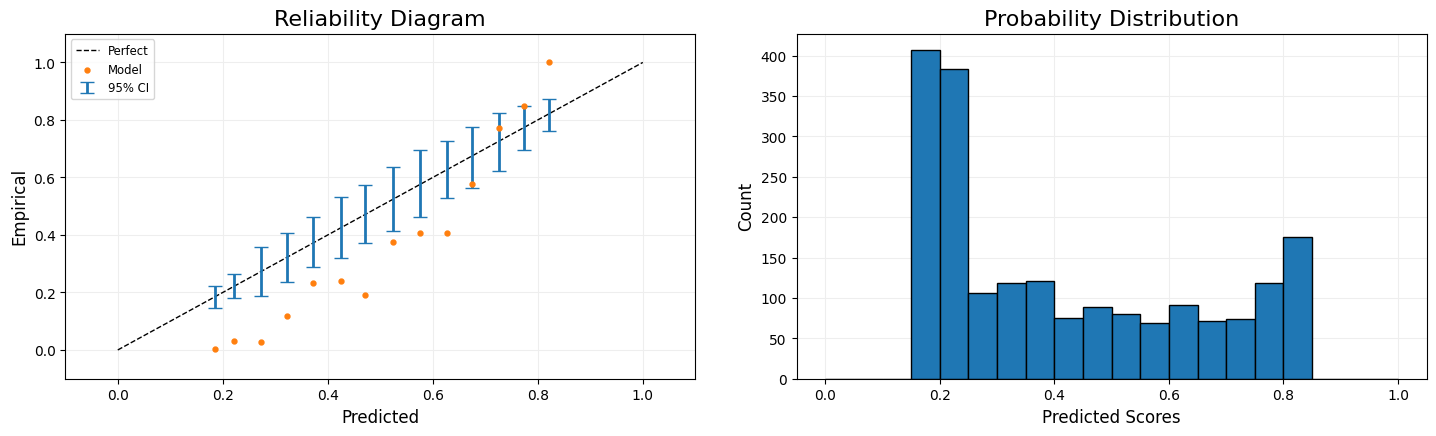

In [23]:
# Predict probabilities for the test set
# 'predict_proba' returns the probability of each class, [:,1] extracts the probability of the positive class
preds_uncalibrated_test = lgbm_clf.predict_proba(X_test)[:, 1]

# Calculate and print the log loss on the test set
# Log loss measures the accuracy of the probabilistic predictions
print(f"LightGBM logloss on the test set: {log_loss(y_test, preds_uncalibrated_test):.5f}")

# Calculate and print the ROC-AUC score on the test set
# ROC-AUC measures the ability of the classifier to distinguish between classes
print(f"LightGBM ROC-AUC on the test set: {roc_auc_score(y_test, preds_uncalibrated_test):.5f}")

# Calculate and print the F1 score on the test set
# F1 score is the harmonic mean of precision and recall, using binary predictions
print(f"LightGBM F1 on the test set: {f1_score(y_test, lgbm_clf.predict(X_test)):.5f}")

# Print a blank line for better readability of output
print()

# Plot the reliability diagram for the test set predictions
# Set the figure size
plt.figure(figsize=(15, 5))

# Create and display the reliability diagram with histogram
# 'mli.plot_reliability_diagram' is assumed to be a function from an external library to plot the reliability diagram
# 'show_histogram=True' adds a histogram of predicted probabilities
rd = mli.plot_reliability_diagram(y_test, preds_uncalibrated_test, show_histogram=True)


We can see our log-loss has definitely reduced here. Since we have many data points with model predictions close to 0, we can see the benefit of using the Ml-insights package (and its logit scaling feature) here.

#Sklearn Plots

**The reliability curve** visually identifies whether a model is calibrated. Here's how it's created:

- Bin the data: Divide predicted outputs into bins from 0 to 1. For example, using 0.1 intervals, create 10 bins.

- Assign data points: Place data points into these bins based on their predicted values. For instance, if five data points (0.05, 0.05, 0.02, 0.01, 0.02) fall into the 0-0.1 bin, the average prediction is 0.03.

- Plot points: On the X-axis, plot the average prediction (0.03). On the Y-axis, plot the empirical probability—the fraction of data points with ground truth equal to 1. If 1 out of 5 points has a ground truth of 1, the Y value is 0.2. Thus, the first point is [0.03, 0.2].

- Form the line: Repeat for all bins, connect the points to form a line, and compare it to the y = x line.
If points are above y = x, the model under-predicts the true probability; if below, it over-predicts. This plot can be constructed using Sklearn.

Reference - https://towardsdatascience.com/classifier-calibration-7d0be1e05452

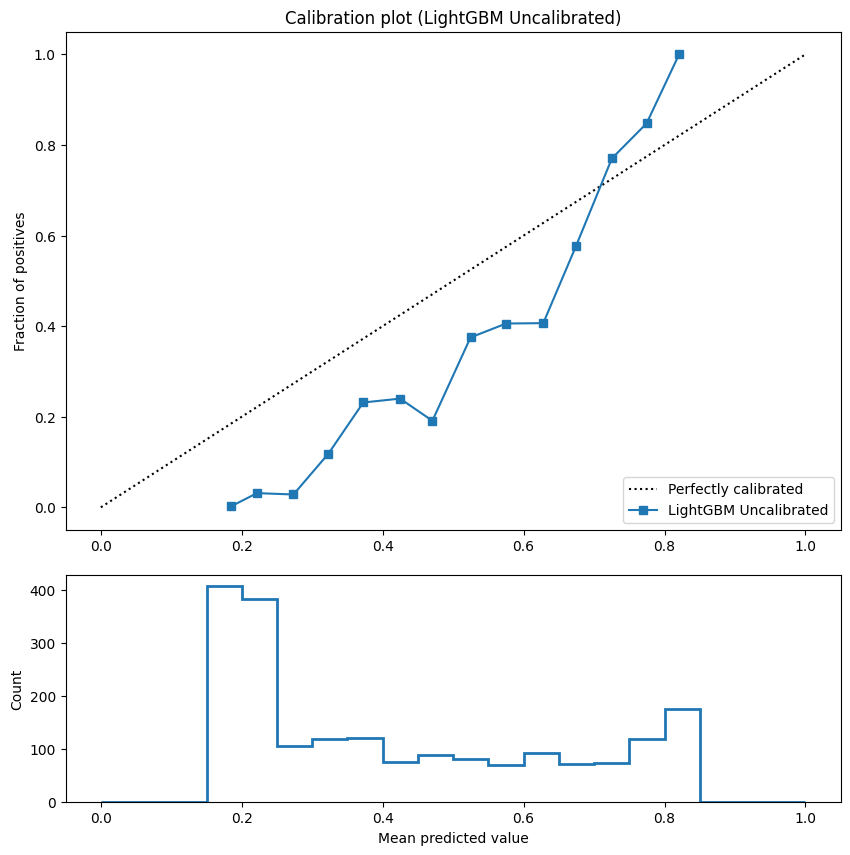

In [24]:
from sklearn.calibration import calibration_curve


def plot_calibration_curve(name, fig_index, probs):
    """Plot calibration curve for est w/o and with calibration. """

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    frac_of_pos, mean_pred_value = calibration_curve(y_test, probs, n_bins=20)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label=f'{name}')
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(f'Calibration plot ({name})')

    ax2.hist(probs, range=(0, 1), bins=20, label=name, histtype="step", lw=2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")

plot_calibration_curve("LightGBM Uncalibrated", 1, preds_uncalibrated_test)


#Platt Scaling

Platt Scaling assumes that there is a logistic relationship between the model predictions and the true probabilities.

We simply use a logistic regressor to fit on the model predictions for the validation set and the true probabilities of this validation set as the outputs.

In [25]:
# Fit Platt scaling (logistic calibration)
lr = LogisticRegression(C=99999999999, solver='lbfgs')
lr.fit(preds_uncalibrated_val.reshape(-1,1), y_val)

LogisticRegression(C=99999999999)

LightGBM logloss on the test set: 0.30868
LightGBM ROC-AUC on the test set: 0.92840



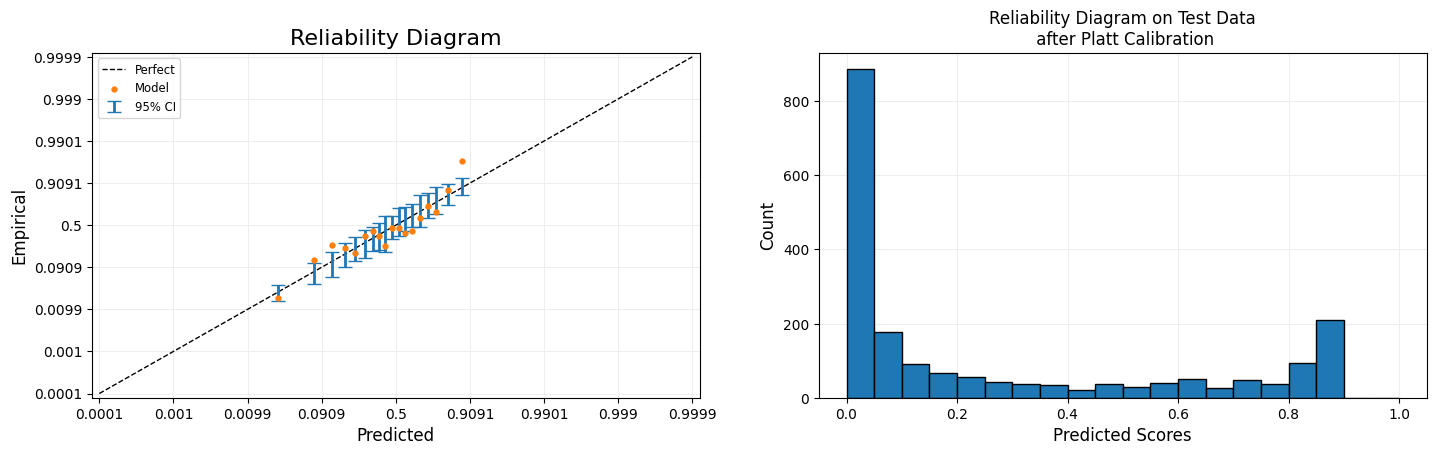

In [26]:
testset_platt_probs = lr.predict_proba(preds_uncalibrated_test.reshape(-1,1))[:,1]
print(f"LightGBM logloss on the test set: {log_loss(y_test, testset_platt_probs):.5f}")
print(f"LightGBM ROC-AUC on the test set: {roc_auc_score(y_test, testset_platt_probs):.5f}")
print()
plt.figure(figsize=(15,5))
mli.plot_reliability_diagram(y_test, testset_platt_probs,show_histogram=True,scaling='logit');
plt.title('Reliability Diagram on Test Data\n after Platt Calibration');

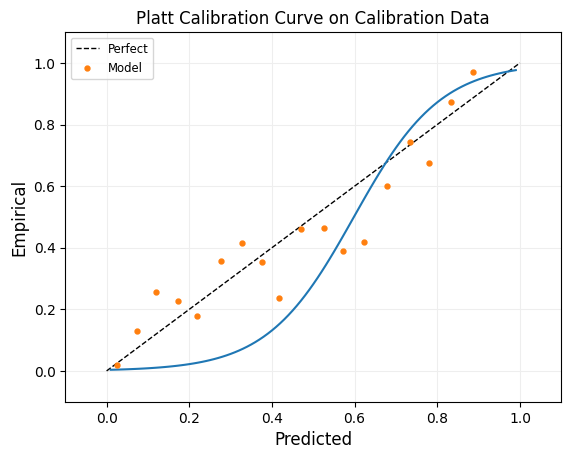

In [27]:
mli.plot_reliability_diagram(y_test, testset_platt_probs,error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, lr.predict_proba(tvec.reshape(-1,1))[:,1]);
plt.title('Platt Calibration Curve on Calibration Data');

In [28]:
print('Platt calibrated log_loss = {}'.format(log_loss(y_test, testset_platt_probs)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_test, preds_uncalibrated_test)))
print('Platt calibrated ROC_AUC = {}'.format(roc_auc_score(y_test, testset_platt_probs)))
print('Uncalibrated ROC_AUC = {}'.format(roc_auc_score(y_test, preds_uncalibrated_test)))

Platt calibrated log_loss = 0.3086776231887612
Uncalibrated log_loss = 0.41463655756079
Platt calibrated ROC_AUC = 0.9284029225454948
Uncalibrated ROC_AUC = 0.9284029225454948


#Isotonic Regression

This method combines Bayesian classifiers and Decision trees to calibrate models and works better than Platt scaling when we have enough data for it to fit. The detailed algorithm can be found here: https://cseweb.ucsd.edu/~elkan/calibrated.pdf

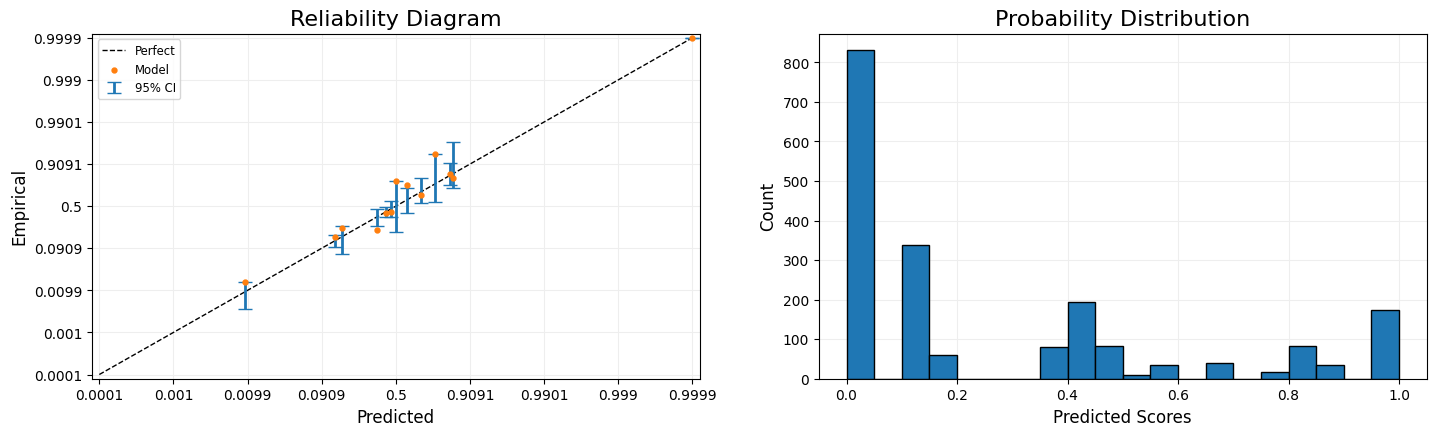

In [29]:
iso = IsotonicRegression(out_of_bounds = 'clip')
iso.fit(preds_uncalibrated_val, y_val)
testset_iso_probs = iso.predict(preds_uncalibrated_test)
plt.figure(figsize=(15,5))
mli.plot_reliability_diagram(y_test, testset_iso_probs,show_histogram=True,scaling='logit');


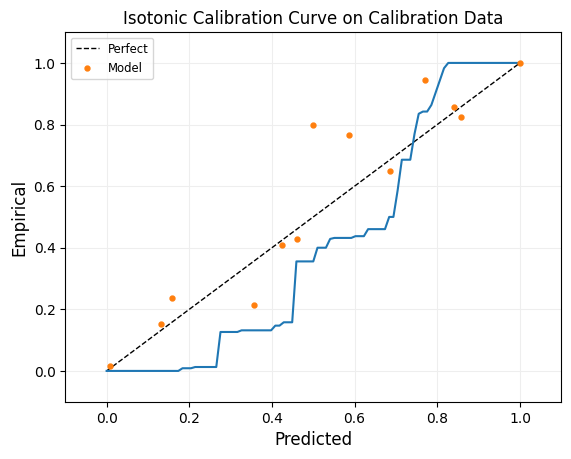

In [30]:
mli.plot_reliability_diagram(y_test, testset_iso_probs,error_bars=False);
tvec = np.linspace(0, 1, 99)
plt.plot(tvec, iso.predict(tvec));
plt.title('Isotonic Calibration Curve on Calibration Data');

This seems to work better than Platt scaling for our data. Although it would be much wiser to come to such conclusions after averaging the results of these experiments over different data splits and random seeds or using cross-validation

In [31]:
print('Isotonic calibrated log_loss = {}'.format(log_loss(y_test, testset_iso_probs)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_test, preds_uncalibrated_test)))
print('Isotonic calibrated ROC_AUC = {}'.format(roc_auc_score(y_test, testset_iso_probs)))
print('Uncalibrated ROC_AUC = {}'.format(roc_auc_score(y_test, preds_uncalibrated_test)))

Isotonic calibrated log_loss = 0.2962499263928603
Uncalibrated log_loss = 0.41463655756079
Isotonic calibrated ROC_AUC = 0.9279572897469208
Uncalibrated ROC_AUC = 0.9284029225454948


# Spline Calib

The Spline Calib algorithm uses a smooth cubic polynomial (which is chosen to minimize a certain loss) and is fit on the model predictions on the validation set and its true probabilities.

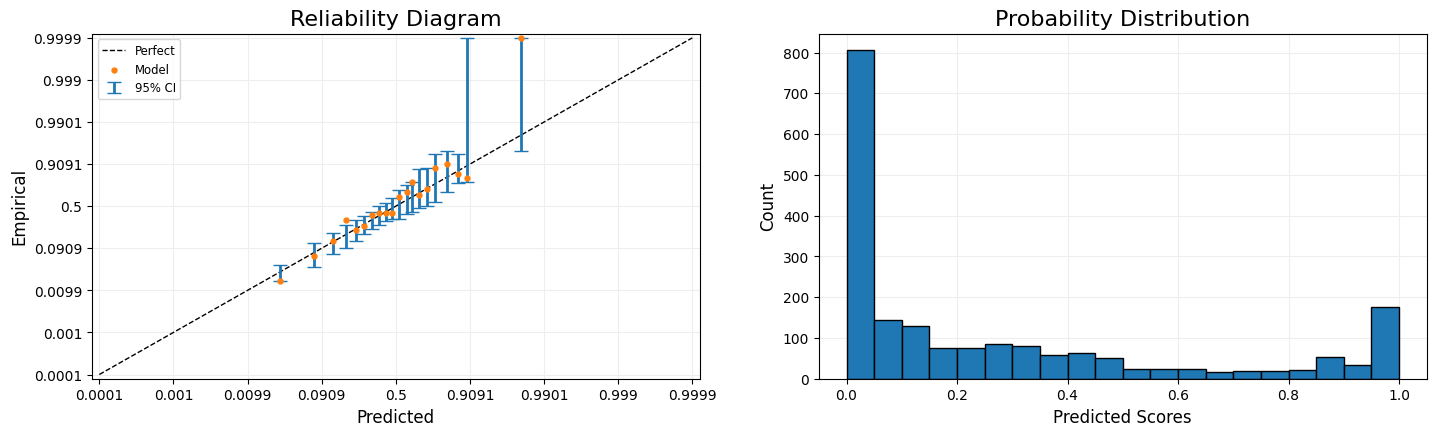

In [32]:
splinecalib = mli.SplineCalib()
splinecalib.fit(preds_uncalibrated_val, y_val)
testset_splinecalib_probs = splinecalib.predict(preds_uncalibrated_test)
plt.figure(figsize=(15,5))
mli.plot_reliability_diagram(y_test, testset_splinecalib_probs,show_histogram=True,scaling='logit');


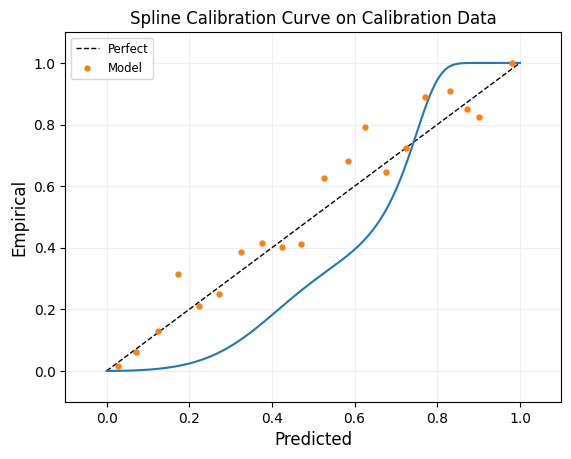

In [33]:
mli.plot_reliability_diagram(y_test, testset_splinecalib_probs,error_bars=False);
tvec = np.linspace(0, 1, 999)
plt.plot(tvec, splinecalib.predict(tvec));
plt.title('Spline Calibration Curve on Calibration Data');

In [34]:
print('Spline calibrated log_loss = {}'.format(log_loss(y_test, testset_splinecalib_probs)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_test, preds_uncalibrated_test)))
print('Spline calibrated ROC_AUC = {}'.format(roc_auc_score(y_test, testset_splinecalib_probs)))
print('Uncalibrated ROC_AUC = {}'.format(roc_auc_score(y_test, preds_uncalibrated_test)))

Spline calibrated log_loss = 0.294975215803674
Uncalibrated log_loss = 0.41463655756079
Spline calibrated ROC_AUC = 0.9284029225454948
Uncalibrated ROC_AUC = 0.9284029225454948


#Sklearn Comparision

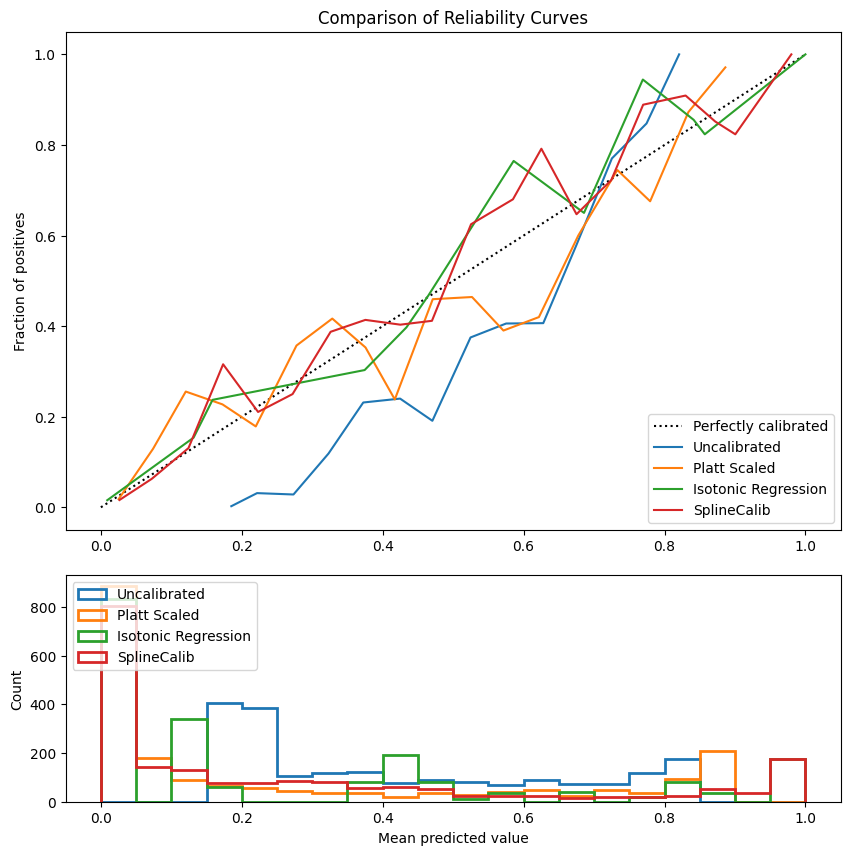

In [35]:
# Create a figure and two subplots: one for the reliability curve and one for the histograms
fig = plt.figure(0, figsize=(10, 10))

# First subplot: reliability curve
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

# Second subplot: histograms of predicted probabilities
ax2 = plt.subplot2grid((3, 1), (2, 0))

# Plot the perfectly calibrated line (y=x) for reference
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# Calculate the calibration curve for the uncalibrated predictions
frac_of_pos_0, mean_pred_value_0 = calibration_curve(y_test, preds_uncalibrated_test, n_bins=20)
# Plot the calibration curve for the uncalibrated predictions
ax1.plot(mean_pred_value_0, frac_of_pos_0, label='Uncalibrated')

# Calculate the calibration curve for the Platt scaled predictions
frac_of_pos_1, mean_pred_value_1 = calibration_curve(y_test, testset_platt_probs, n_bins=20)
# Plot the calibration curve for the Platt scaled predictions
ax1.plot(mean_pred_value_1, frac_of_pos_1, label='Platt Scaled')

# Calculate the calibration curve for the isotonic regression predictions
frac_of_pos_2, mean_pred_value_2 = calibration_curve(y_test, testset_iso_probs, n_bins=20)
# Plot the calibration curve for the isotonic regression predictions
ax1.plot(mean_pred_value_2, frac_of_pos_2, label='Isotonic Regression')

# Calculate the calibration curve for the SplineCalib predictions
frac_of_pos_3, mean_pred_value_3 = calibration_curve(y_test, testset_splinecalib_probs, n_bins=20)
# Plot the calibration curve for the SplineCalib predictions
ax1.plot(mean_pred_value_3, frac_of_pos_3, label='SplineCalib')

# Set the y-axis label for the reliability curve
ax1.set_ylabel("Fraction of positives")
# Set the y-axis limits for the reliability curve
ax1.set_ylim([-0.05, 1.05])
# Add a legend to the reliability curve plot
ax1.legend(loc="lower right")
# Set the title for the reliability curve plot
ax1.set_title(f'Comparison of Reliability Curves')

# Plot histograms of the predicted probabilities for each method
ax2.hist(preds_uncalibrated_test, range=(0, 1), bins=20, histtype="step", lw=2, label='Uncalibrated')
ax2.hist(testset_platt_probs, range=(0, 1), bins=20, histtype="step", lw=2, label='Platt Scaled')
ax2.hist(testset_iso_probs, range=(0, 1), bins=20, histtype="step", lw=2, label='Isotonic Regression')
ax2.hist(testset_splinecalib_probs, range=(0, 1), bins=20, histtype="step", lw=2, label='SplineCalib')

# Set the x-axis label for the histogram plot
ax2.set_xlabel("Mean predicted value")
# Set the y-axis label for the histogram plot
ax2.set_ylabel("Count")
# Add a legend to the histogram plot
ax2.legend(loc="upper left")

# Show the plot
plt.show()


In [36]:
(iso.predict(preds_uncalibrated_test)>=0.5).astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [37]:
print('Uncalibrated log_loss = {}'.format(log_loss(y_test, preds_uncalibrated_test)))
print('Uncalibrated ROC_AUC = {}'.format(roc_auc_score(y_test, preds_uncalibrated_test)))
print(f"Uncalibrated F1 on the test set: {f1_score(y_test, lgbm_clf.predict(X_test)):.5f}")
print()
print('Platt calibrated log_loss = {}'.format(log_loss(y_test, testset_platt_probs)))
print('Platt calibrated ROC_AUC = {}'.format(roc_auc_score(y_test, testset_platt_probs)))
print(f"Platt calibrated F1 on the test set: {f1_score(y_test, lr.predict(preds_uncalibrated_test.reshape(-1,1))):.5f}")

print()
print('Isotonic calibrated log_loss = {}'.format(log_loss(y_test, testset_iso_probs)))
print('Isotonic calibrated ROC_AUC = {}'.format(roc_auc_score(y_test, testset_iso_probs)))
print(f"Isotonic calibrated F1 on the test set: {f1_score(y_test,(iso.predict(preds_uncalibrated_test)>=0.5).astype(int)):.5f}")

print()
print('Spline calibrated log_loss = {}'.format(log_loss(y_test, testset_splinecalib_probs)))
print('Spline calibrated ROC_AUC = {}'.format(roc_auc_score(y_test, testset_splinecalib_probs)))
print(f"Uncalibrated F1 on the test set: {f1_score(y_test, (splinecalib.predict(preds_uncalibrated_test)>=0.5)):.5f}")


Uncalibrated log_loss = 0.41463655756079
Uncalibrated ROC_AUC = 0.9284029225454948
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Uncalibrated F1 on the test set: 0.75545

Platt calibrated log_loss = 0.3086776231887612
Platt calibrated ROC_AUC = 0.9284029225454948
Platt calibrated F1 on the test set: 0.75092

Isotonic calibrated log_loss = 0.2962499263928603
Isotonic calibrated ROC_AUC = 0.9279572897469208
Isotonic calibrated F1 on the test set: 0.73508

Spline calibrated log_loss = 0.294975215803674
Spline calibrated ROC_AUC = 0.9284029225454948
Uncalibrated F1 on the test set: 0.74074


#ECE and OE

Reference - https://medium.com/@wolframalphav1.0/evaluate-the-performance-of-a-model-in-high-risk-applications-using-expected-calibration-error-and-dbc392c68318

Expected Calibration Error and its Flaws:

ECE is often used as a metric to measure how well a model is calibrated.

Here is how ECE is formally calculated.

1. Choose n the number of bins as we did earlier
For each bin calculate the average of the model predictions of the data points belonging to that bin and normalize it by the number of data points in that bin.
For each bin also calculate the fraction of true positives.
2. Now for each bin calculate the absolute difference between the values calculated in step 3 and step 2and multiply this absolute difference by the number of data points in that bin.
3. Add the results for all bins calculated in step 4 and normalize this added sum by the total number of samples in all the bins.

The ECE quantifies the overall calibration error by averaging the absolute differences between predicted probabilities and actual outcomes, weighted by the number of samples in each bin. The OE focuses on the specific error due to overconfidence by only considering cases where the predicted probability exceeds the actual accuracy.

### Expected Calibration Error (ECE)

The Expected Calibration Error (ECE) measures the discrepancy between predicted probabilities and actual outcomes. It is calculated as:

$$
\text{ECE} = \sum_{m=1}^M \frac{|B_m|}{n} \left| \text{acc}(B_m) - \text{conf}(B_m) \right|
$$

### Overconfidence Error (OE)

The Overconfidence Error (OE) measures the degree to which the model's predicted probabilities are overconfident compared to actual outcomes. It is calculated as:

$$
\text{OE} = \sum_{m=1}^M \frac{|B_m|}{n} \cdot \text{conf}(B_m) \cdot \max(\text{conf}(B_m) - \text{acc}(B_m), 0)
$$


However, in our case above, the distribution of the data points across the bins was not very uniform (since most data points belonged to the first bin) and thus it is imperative to select the bins for ECE accordingly. We can see how the number of bins is directly affecting ECE in the algorithm.

**For instance for only 5 bins, the uncalibrated model seemed to have lesser calibration error than all the other methods. However when we increase the number of bins, we can see that model calibration has actually helped in our case.**

In the code snippets below, this effect can be verified.


In [38]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Define a function to calculate calibration error
def calibration_error(y_true, y_prob, n_bins=5, strategy='uniform', return_expected_calibration_error=True):
    # Determine the bin edges based on the chosen strategy
    if strategy == 'quantile':  # Determine bin edges by distribution of data
        quantiles = np.linspace(0, 1, n_bins + 1)  # Create quantiles
        bins = np.percentile(y_prob, quantiles * 100)  # Determine bin edges based on percentiles
        bins[-1] = bins[-1] + 1e-8  # Ensure the last bin edge is slightly larger to include the maximum value
    elif strategy == 'uniform':  # Use uniform binning
        bins = np.linspace(0., 1. + 1e-8, n_bins + 1)  # Create uniform bins
    else:
        raise ValueError("Invalid entry to 'strategy' input. Strategy must be either 'quantile' or 'uniform'.")

    # Get the maximum predicted probability for each sample
    y_prob_max = np.max(y_prob, axis=-1)
    # Assign each probability to a bin
    binids = np.digitize(y_prob_max, bins) - 1

    # Determine if the predictions are correct
    y_correct_classified = (np.argmax(y_true, axis=-1) == np.argmax(y_prob, axis=-1)).astype(int)

    # Sum of predicted probabilities in each bin
    bin_sums = np.bincount(binids, weights=y_prob_max, minlength=len(bins))
    # Sum of correctly classified samples in each bin
    bin_true = np.bincount(binids, weights=y_correct_classified, minlength=len(bins))
    # Total number of samples in each bin
    bin_total = np.bincount(binids, minlength=len(bins))

    # Identify non-empty bins
    nonzero = bin_total != 0

    # Calculate the true probability for each bin (accuracy)
    prob_true = bin_true[nonzero] / bin_total[nonzero]

    # Calculate the predicted probability for each bin (confidence)
    prob_pred = bin_sums[nonzero] / bin_total[nonzero]

    # Calculate the Expected Calibration Error (ECE)
    expected_calibration_error = np.sum(bin_total[nonzero] * np.abs(prob_true - prob_pred)) / bin_total[nonzero].sum()

    # Calculate the Overconfidence Error (OE)
    overconfidence_error = np.sum(
        bin_total[nonzero] * prob_pred * np.max(
            np.concatenate(((prob_pred - prob_true).reshape(-1, 1), np.zeros((1, len(prob_pred))).T), axis=1),
            axis=-1
        )
    ) / bin_total[nonzero].sum()

    # Return the true probabilities, predicted probabilities, ECE, and OE
    return prob_true, prob_pred, expected_calibration_error, overconfidence_error


These metrics provide insight into how well a model's predicted probabilities reflect the true likelihood of outcomes, which is crucial for applications where probabilistic predictions are used for decision-making.

In [39]:
lgbm_clf.predict_proba(X_test)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


array([[0.37146036, 0.62853964],
       [0.42052653, 0.57947347],
       [0.44799147, 0.55200853],
       ...,
       [0.41515743, 0.58484257],
       [0.48088102, 0.51911898],
       [0.81784019, 0.18215981]])

In [40]:
_,_,ECE,OE = calibration_error(y_test,lgbm_clf.predict_proba(X_test))
print(f'Uncalibrated LGBM ECE = {ECE} OE = {OE}')
print()
_,_,ECE,OE = calibration_error(y_test,lr.predict_proba(preds_uncalibrated_test.reshape(-1,1)))
print(f'Platt Calibrated LGBM ECE = {ECE} OE = {OE}')
print()
_,_,ECE,OE = calibration_error(y_test,np.concatenate((1-iso.predict(preds_uncalibrated_test).reshape(-1,1),iso.predict(preds_uncalibrated_test).reshape(-1,1)),axis=1))
print(f'Isotonic Calibrated LGBM ECE = {ECE} OE = {OE}')
print()
_,_,ECE,OE = calibration_error(y_test,np.concatenate((1-splinecalib.predict(preds_uncalibrated_test).reshape(-1,1),splinecalib.predict(preds_uncalibrated_test).reshape(-1,1)),axis=1))
print(f'Spline Calibrated LGBM ECE = {ECE} OE = {OE}')
print()


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Uncalibrated LGBM ECE = 0.06537938741660275 OE = 0.04977480595374452

Platt Calibrated LGBM ECE = 0.14194660258154507 OE = 0.1232413208540819

Isotonic Calibrated LGBM ECE = 0.16695782451637742 OE = 0.10623892289708121

Spline Calibrated LGBM ECE = 0.13348309561816218 OE = 0.09876346959036143



In [41]:
#5 bins
_,_,ECE,OE = calibration_error(y_test,lgbm_clf.predict_proba(X_test))
print(f'Uncalibrated LGBM ECE = {ECE} OE = {OE}')
print()
_,_,ECE,OE = calibration_error(y_test,lr.predict_proba(preds_uncalibrated_test.reshape(-1,1)))
print(f'Platt Calibrated LGBM ECE = {ECE} OE = {OE}')
print()
_,_,ECE,OE = calibration_error(y_test,np.concatenate((1-iso.predict(preds_uncalibrated_test).reshape(-1,1),iso.predict(preds_uncalibrated_test).reshape(-1,1)),axis=1))
print(f'Isotonic Calibrated LGBM ECE = {ECE} OE = {OE}')
print()
_,_,ECE,OE = calibration_error(y_test,np.concatenate((1-splinecalib.predict(preds_uncalibrated_test).reshape(-1,1),splinecalib.predict(preds_uncalibrated_test).reshape(-1,1)),axis=1))
print(f'Spline Calibrated LGBM ECE = {ECE} OE = {OE}')
print()


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Uncalibrated LGBM ECE = 0.06537938741660275 OE = 0.04977480595374452

Platt Calibrated LGBM ECE = 0.14194660258154507 OE = 0.1232413208540819

Isotonic Calibrated LGBM ECE = 0.16695782451637742 OE = 0.10623892289708121

Spline Calibrated LGBM ECE = 0.13348309561816218 OE = 0.09876346959036143



In [42]:
#50 bins
_,_,ECE,OE = calibration_error(y_test,lgbm_clf.predict_proba(X_test),n_bins=50)
print(f'Uncalibrated LGBM ECE = {ECE} OE = {OE}')
print()
_,_,ECE,OE = calibration_error(y_test,lr.predict_proba(preds_uncalibrated_test.reshape(-1,1)),n_bins=50)
print(f'Platt Calibrated LGBM ECE = {ECE} OE = {OE}')
print()
_,_,ECE,OE = calibration_error(y_test,np.concatenate((1-iso.predict(preds_uncalibrated_test).reshape(-1,1),iso.predict(preds_uncalibrated_test).reshape(-1,1)),axis=1),n_bins=50)
print(f'Isotonic Calibrated LGBM ECE = {ECE} OE = {OE}')
print()
_,_,ECE,OE = calibration_error(y_test,np.concatenate((1-splinecalib.predict(preds_uncalibrated_test).reshape(-1,1),splinecalib.predict(preds_uncalibrated_test).reshape(-1,1)),axis=1),n_bins=50)
print(f'Spline Calibrated LGBM ECE = {ECE} OE = {OE}')
print()


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Uncalibrated LGBM ECE = 0.15844535674219964 OE = 0.08650205298249782

Platt Calibrated LGBM ECE = 0.18430651736100262 OE = 0.13503457264043853

Isotonic Calibrated LGBM ECE = 0.23574740032163458 OE = 0.13514470514199758

Spline Calibrated LGBM ECE = 0.16426792518663383 OE = 0.11368021590837088



In [43]:
#500 bins
_,_,ECE,OE = calibration_error(y_test,lgbm_clf.predict_proba(X_test),n_bins=500)
print(f'Uncalibrated LGBM ECE = {ECE} OE = {OE}')
print()
_,_,ECE,OE = calibration_error(y_test,lr.predict_proba(preds_uncalibrated_test.reshape(-1,1)),n_bins=500)
print(f'Platt Calibrated LGBM ECE = {ECE} OE = {OE}')
print()
_,_,ECE,OE = calibration_error(y_test,np.concatenate((1-iso.predict(preds_uncalibrated_test).reshape(-1,1),iso.predict(preds_uncalibrated_test).reshape(-1,1)),axis=1),n_bins=500)
print(f'Isotonic Calibrated LGBM ECE = {ECE} OE = {OE}')
print()
_,_,ECE,OE = calibration_error(y_test,np.concatenate((1-splinecalib.predict(preds_uncalibrated_test).reshape(-1,1),splinecalib.predict(preds_uncalibrated_test).reshape(-1,1)),axis=1),n_bins=500)
print(f'Spline Calibrated LGBM ECE = {ECE} OE = {OE}')
print()


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Uncalibrated LGBM ECE = 0.27735636999873253 OE = 0.1277407980207083

Platt Calibrated LGBM ECE = 0.23721763738521814 OE = 0.15336728940174515

Isotonic Calibrated LGBM ECE = 0.26884927787465873 OE = 0.14777831288094664

Spline Calibrated LGBM ECE = 0.2353188031466242 OE = 0.13909529043271873



In [44]:
#5000 bins
_,_,ECE,OE = calibration_error(y_test,lgbm_clf.predict_proba(X_test),n_bins=5000)
print(f'Uncalibrated LGBM ECE = {ECE} OE = {OE}')
print()
_,_,ECE,OE = calibration_error(y_test,lr.predict_proba(preds_uncalibrated_test.reshape(-1,1)),n_bins=5000)
print(f'Platt Calibrated LGBM ECE = {ECE} OE = {OE}')
print()
_,_,ECE,OE = calibration_error(y_test,np.concatenate((1-iso.predict(preds_uncalibrated_test).reshape(-1,1),iso.predict(preds_uncalibrated_test).reshape(-1,1)),axis=1),n_bins=5000)
print(f'Isotonic Calibrated LGBM ECE = {ECE} OE = {OE}')
print()
_,_,ECE,OE = calibration_error(y_test,np.concatenate((1-splinecalib.predict(preds_uncalibrated_test).reshape(-1,1),splinecalib.predict(preds_uncalibrated_test).reshape(-1,1)),axis=1),n_bins=5000)
print(f'Spline Calibrated LGBM ECE = {ECE} OE = {OE}')
print()


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Uncalibrated LGBM ECE = 0.3857071231650443 OE = 0.16290835637131137

Platt Calibrated LGBM ECE = 0.2705904470837723 OE = 0.16485054502692123

Isotonic Calibrated LGBM ECE = 0.26900848003594946 OE = 0.14784523701693356

Spline Calibrated LGBM ECE = 0.2713290952025268 OE = 0.15215914981052392



## Reading References:



- Probability Calibration workshop Youtube Video Series:

 https://www.youtube.com/playlist?list=PLeVfk5xTWHYBw22D52etymvcpxey4QFIk

- Conformal prediction:

  https://www.youtube.com/playlist?list=PLBa0oe-LYIHa68NOJbMxDTMMjT8Is4WkI

- TorchCP:
  
  https://github.com/ml-stat-Sustech/TorchCP

- AWS Fortuna:

  https://aws-fortuna.readthedocs.io/en/latest/

